In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/ml2021spring-hw1/covid.test.csv
/kaggle/input/ml2021spring-hw1/sampleSubmission.csv
/kaggle/input/ml2021spring-hw1/covid.train.csv


In [2]:
import csv

import torch
import numpy as np
from matplotlib.pyplot import figure
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from matplotlib import pyplot as plt


In [3]:
# 超参数
batch_size = 64
learning_rate = 0.001
epochs = 3000
model_path = 'model.pth'
early_stop = 300
target_only = False
weight_decay = 0.1
momentum = 0.1

In [4]:
class covidDataset(Dataset):
    # def __init__(self, filepath, type='train'):
    #     data = np.loadtxt(filepath, skiprows=1, delimiter=',', dtype=np.float32)
    #     self.len = data.shape[0]
    #     if type == 'train':
    #         self.x_data = torch.from_numpy(data[:, 1:-1])
    #         self.y_data = torch.from_numpy(data[:, [-1]])
    #     else:
    #         self.x_data = torch.from_numpy(data[:, 1:])
    #
    # def __getitem__(self, index):
    #     return self.x_data[index], self.y_data[index]
    #
    # def __len__(self):
    #     return self.len

    def __init__(self,
                 filepath,
                 mode='train',
                 target_only=False):
        self.mode = mode

        # Read data into numpy arrays
        data = np.loadtxt(filepath, skiprows=1, delimiter=',', dtype=np.float32)
        data = data[:, 1:]

        if not target_only:
            feats = list(range(93))
        else:
            # TODO: Using 40 states & 2 tested_positive features (indices = 57 & 75)
            feats = list(range(40))
            feats.append(57)
            feats.append(75)

        if mode == 'test':
            # Testing data
            # data: 893 x 93 (40 states + day 1 (18) + day 2 (18) + day 3 (17))
            data = data[:, feats]
            self.data = torch.from_numpy(data)
        else:
            # Training data (train/dev sets)
            # data: 2700 x 94 (40 states + day 1 (18) + day 2 (18) + day 3 (18))
            target = data[:, -1]
            data = data[:, feats]

            # Splitting training data into train & dev sets
            if mode == 'train':
                indices = [i for i in range(len(data)) if i % 10 != 0]
            elif mode == 'dev':
                indices = [i for i in range(len(data)) if i % 10 == 0]

            # Convert data into PyTorch tensors
            self.data = torch.from_numpy(data[indices])
            self.target = torch.from_numpy(target[indices])

        # Normalize features (you may remove this part to see what will happen)
        # self.data[:, 40:] = \
        #     (self.data[:, 40:] - self.data[:, 40:].mean(dim=0, keepdim=True)) \
        #     / self.data[:, 40:].std(dim=0, keepdim=True)

        self.dim = self.data.shape[1]

        print('Finished reading the {} set of COVID19 Dataset ({} samples found, each dim = {})'
              .format(mode, len(self.data), self.dim))

    def __getitem__(self, index):
        # Returns one sample at a time
        if self.mode in ['train', 'dev']:
            # For training
            return self.data[index], self.target[index]
        else:
            # For testing (no target)
            return self.data[index]

    def __len__(self):
        # Returns the size of the dataset
        return len(self.data)



In [5]:
def dataloader(path, mode, batch_size, n_jobs=0, target_only=False):
    ''' Generates a dataset, then is put into a dataloader. '''
    dataset = covidDataset(path, mode=mode, target_only=target_only)  # Construct dataset
    dataloader = DataLoader(
        dataset=dataset,
        batch_size=batch_size,
        shuffle=(mode == 'train'),
        num_workers=n_jobs,                         # how many subprocesses to use for data loading. 0 means that the data will be loaded in the main process
        pin_memory=True)                            # Construct dataloader
    return dataloader




In [6]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


In [7]:
class Model(torch.nn.Module):
    def __init__(self, features):
        super(Model, self).__init__()
        self.linear1 = torch.nn.Linear(features, 128)

        self.linear2 = torch.nn.Linear(128, 64)

        self.linear3 = torch.nn.Linear(64, 32)

        self.linear4 = torch.nn.Linear(32, 8)

        self.linear5 = torch.nn.Linear(8, 1)
        self.relu = torch.nn.ReLU()



    def forward(self, x):
        in_size = x.size(0)
        x = self.relu(self.linear1(x))
        x = self.relu(self.linear2(x))
        x = self.relu(self.linear3(x))
        x = self.relu(self.linear4(x))
        x = self.relu(self.linear5(x))
        x = x.view(in_size)
        return x


In [8]:

# load data
tr_path = '../input/ml2021spring-hw1/covid.train.csv'
tt_path = '../input/ml2021spring-hw1/covid.test.csv'
train_loader = dataloader(tr_path, 'train', batch_size, target_only=target_only)
dev_loader = dataloader(tr_path, 'dev', batch_size, target_only=target_only)
test_loader = dataloader(tt_path, 'test', batch_size, target_only=target_only)



Finished reading the train set of COVID19 Dataset (2430 samples found, each dim = 93)
Finished reading the dev set of COVID19 Dataset (270 samples found, each dim = 93)
Finished reading the test set of COVID19 Dataset (893 samples found, each dim = 93)


In [9]:

model = Model(train_loader.dataset.dim).to(device)

# construct loss and optimizer
criterion = torch.nn.MSELoss(reduction='mean')
optimizer = torch.optim.Adam(model.parameters(),
                             lr=learning_rate,
                             weight_decay=weight_decay)
# optimizer = torch.optim.SGD(model.parameters(),
#                             lr=learning_rate,
#                             weight_decay=weight_decay,
#                             momentum=momentum)


# lossRecord = [0.0 for _ in range(epochs)]


In [10]:
def load_model():
    pass


In [11]:

def train(tr_set, dv_set):
    # running_loss = 0.0
    # for batch_idx, data in enumerate(train_loader, 0):
    #     inputs, target = data
    #     inputs, target = inputs.to(device), target.to(device)
    #     optimizer.zero_grad()
    #
    #     outputs = model(inputs)
    #     loss = criterion(outputs, target)
    #     loss.backward()
    #     optimizer.step()
    #
    #     running_loss += loss.item()
    #     lossRecord[epoch] += loss.item()
    #     if batch_idx % 10 == 0:
    #         print('[%d, %5d] loss: %.3f' % (epoch, batch_idx, running_loss / 10))
    #         running_loss = 0.0

    min_mse = 10000.
    loss_record = {'train': [], 'dev': []}  # for recording training loss
    early_stop_cnt = 0
    epoch = 0
    while epoch < epochs:
        model.train()  # set model to training mode
        for x, y in tr_set:  # iterate through the dataloader
            optimizer.zero_grad()  # set gradient to zero
            x, y = x.to(device), y.to(device)  # move data to device (cpu/cuda)
            pred = model(x)  # forward pass (compute output)
            mse_loss = criterion(pred, y)  # compute loss
            mse_loss.backward()  # compute gradient (backpropagation)
            optimizer.step()  # update model with optimizer
            loss_record['train'].append(mse_loss.detach().cpu().item())

        # After each epoch, test your model on the validation (development) set.
        dev_mse = dev(dv_set)
        if dev_mse < min_mse:
            # Save model if your model improved
            min_mse = dev_mse
            print('Saving model (epoch = {:4d}, loss = {:.4f})'
                  .format(epoch + 1, min_mse))
            torch.save(model.state_dict(), model_path)  # Save model to specified path
            early_stop_cnt = 0
        else:
            early_stop_cnt += 1

        epoch += 1
        loss_record['dev'].append(dev_mse)
        # 如果一个epoch有early_stop个epoch没有更新，则停止训练
        if early_stop_cnt > early_stop:
            # Stop training if your model stops improving for "config['early_stop']" epochs.
            break

    print('Finished training after {} epochs'.format(epoch))
    return min_mse, loss_record


In [12]:

def dev(dv_set):
    model.eval()                                # set model to evalutation mode
    total_loss = 0
    for x, y in dv_set:                         # iterate through the dataloader
        x, y = x.to(device), y.to(device)       # move data to device (cpu/cuda)
        with torch.no_grad():                   # disable gradient calculation
            pred = model(x)                     # forward pass (compute output)
            mse_loss = criterion(pred, y)  # compute loss
        total_loss += mse_loss.detach().cpu().item() * len(x)  # accumulate loss
    total_loss = total_loss / len(dv_set.dataset)              # compute averaged loss

    return total_loss


In [13]:

def test():
    model.eval()  # set model to evalutation mode
    preds = []
    for x in test_loader:  # iterate through the dataloader
        x = x.to(device)  # move data to device (cpu/cuda)
        with torch.no_grad():  # disable gradient calculation
            pred = model(x)  # forward pass (compute output)
            preds.append(pred.detach().cpu())  # collect prediction
    preds = torch.cat(preds, dim=0).numpy()  # concatenate all predictions and convert to a numpy array
    return preds


In [14]:

def save_pred(preds, file):
    ''' Save predictions to specified file '''
    with open(file, 'w', newline="") as fp:
        writer = csv.writer(fp)
        writer.writerow(['id', 'tested_positive'])
        for i, p in enumerate(preds):
            writer.writerow([i, p])
    print('Successful save results to {}'.format(file))

In [15]:

def plot_learning_curve(loss_record):
    ''' Plot learning curve of your DNN (train & dev loss) '''
    total_steps = len(loss_record['train'])
    x_1 = range(total_steps)
    x_2 = x_1[::len(loss_record['train']) // len(loss_record['dev'])]
    figure(figsize=(6, 4))
    plt.plot(x_1, loss_record['train'], c='tab:red', label='train')
    plt.plot(x_2, loss_record['dev'], c='tab:cyan', label='dev')
    plt.ylim(0.0, 5.)
    plt.xlabel('Training steps')
    plt.ylabel('MSE loss')
    plt.title('Learning curve')
    plt.legend()
    plt.show()


Saving model (epoch =    1, loss = 44.2446)
Saving model (epoch =    2, loss = 18.4360)
Saving model (epoch =    3, loss = 6.2738)
Saving model (epoch =    4, loss = 5.6395)
Saving model (epoch =    5, loss = 4.0320)
Saving model (epoch =    6, loss = 3.0655)
Saving model (epoch =    7, loss = 2.2270)
Saving model (epoch =    8, loss = 1.7633)
Saving model (epoch =    9, loss = 1.5082)
Saving model (epoch =   11, loss = 1.4643)
Saving model (epoch =   12, loss = 1.3422)
Saving model (epoch =   14, loss = 1.2304)
Saving model (epoch =   16, loss = 1.1859)
Saving model (epoch =   18, loss = 1.1647)
Saving model (epoch =   19, loss = 1.1531)
Saving model (epoch =   21, loss = 1.1395)
Saving model (epoch =   24, loss = 1.1075)
Saving model (epoch =   33, loss = 1.0888)
Saving model (epoch =   41, loss = 1.0633)
Saving model (epoch =   46, loss = 1.0276)
Saving model (epoch =   51, loss = 1.0117)
Saving model (epoch =   58, loss = 1.0074)
Saving model (epoch =   66, loss = 1.0057)
Saving mo

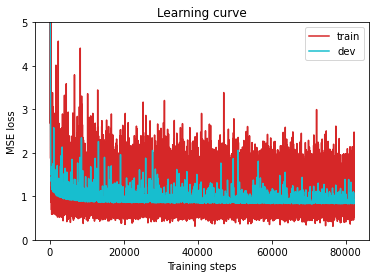

Successful save results to pred.csv


In [16]:

if __name__ == '__main__':
    model_loss, model_loss_record = train(train_loader, dev_loader)
    plot_learning_curve(model_loss_record)

    preds = test()

    # print(preds.shape)
    # print(type(preds))

    save_pred(preds, 'pred.csv')
